Models loaded successfully!
Test set: 14198 hours (2024-03-13 06:00:00 to 2025-10-27 07:00:00)
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

72-Hour Price Forecast Statistics:
  Mean price: €62.65/MWh
  Min price:  €33.29/MWh at 2024-03-15 12:00:00
  Max price:  €104.05/MWh at 2024-03-14 17:00:00
  LightGBM MAE: €0.46/MWh
  XGBoost MAE:  €0.61/MWh
  Ensemble MAE: €0.42/MWh

EV Charging Requirements:
  Battery capacity: 60.0 kWh
  Initial SOC: 20% (12.0 kWh)
  Target SOC: 100% (60.0 kWh)
  Energy needed: 48.00 kWh
  Energy to charge (with 8% loss): 52.17 kWh
  Max charge rate: 11.0 kW
  Min hours needed: 4.7 hours

Solving optimization problem...


  File "D:\Programs\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Programs\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Programs\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Programs\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


✓ Optimal solution found!

Optimal Charging Schedule:
  Total energy charged: 52.17 kWh
  Energy delivered to battery: 48.00 kWh
  Total cost: €1.92
  Average cost: €0.0368/kWh
  Charging hours used: 5

Charging windows (hours with >0.01 kW):
  Hour 53: 2024-03-15 11:00:00 - 11.00 kW at €36.15/MWh
  Hour 54: 2024-03-15 12:00:00 - 11.00 kW at €33.29/MWh
  Hour 67: 2024-03-16 01:00:00 - 8.17 kW at €39.81/MWh
  Hour 68: 2024-03-16 02:00:00 - 11.00 kW at €37.94/MWh
  Hour 69: 2024-03-16 03:00:00 - 11.00 kW at €37.62/MWh

Flat Charging Baseline:
  Total energy charged: 52.17 kWh
  Energy delivered to battery: 48.00 kWh
  Total cost: €3.27
  Average cost: €0.0626/kWh

Immediate (ASAP) Charging Baseline:
  Total energy charged: 52.17 kWh
  Energy delivered to battery: 48.00 kWh
  Total cost: €4.07
  Average cost: €0.0780/kWh
  Charging duration: 5 hours

COST SAVINGS ANALYSIS
Optimal cost:    €1.92
Flat cost:       €3.27 → Savings: €1.35 (41.2%)
Immediate cost:  €4.07 → Savings: €2.15 (52.8%)

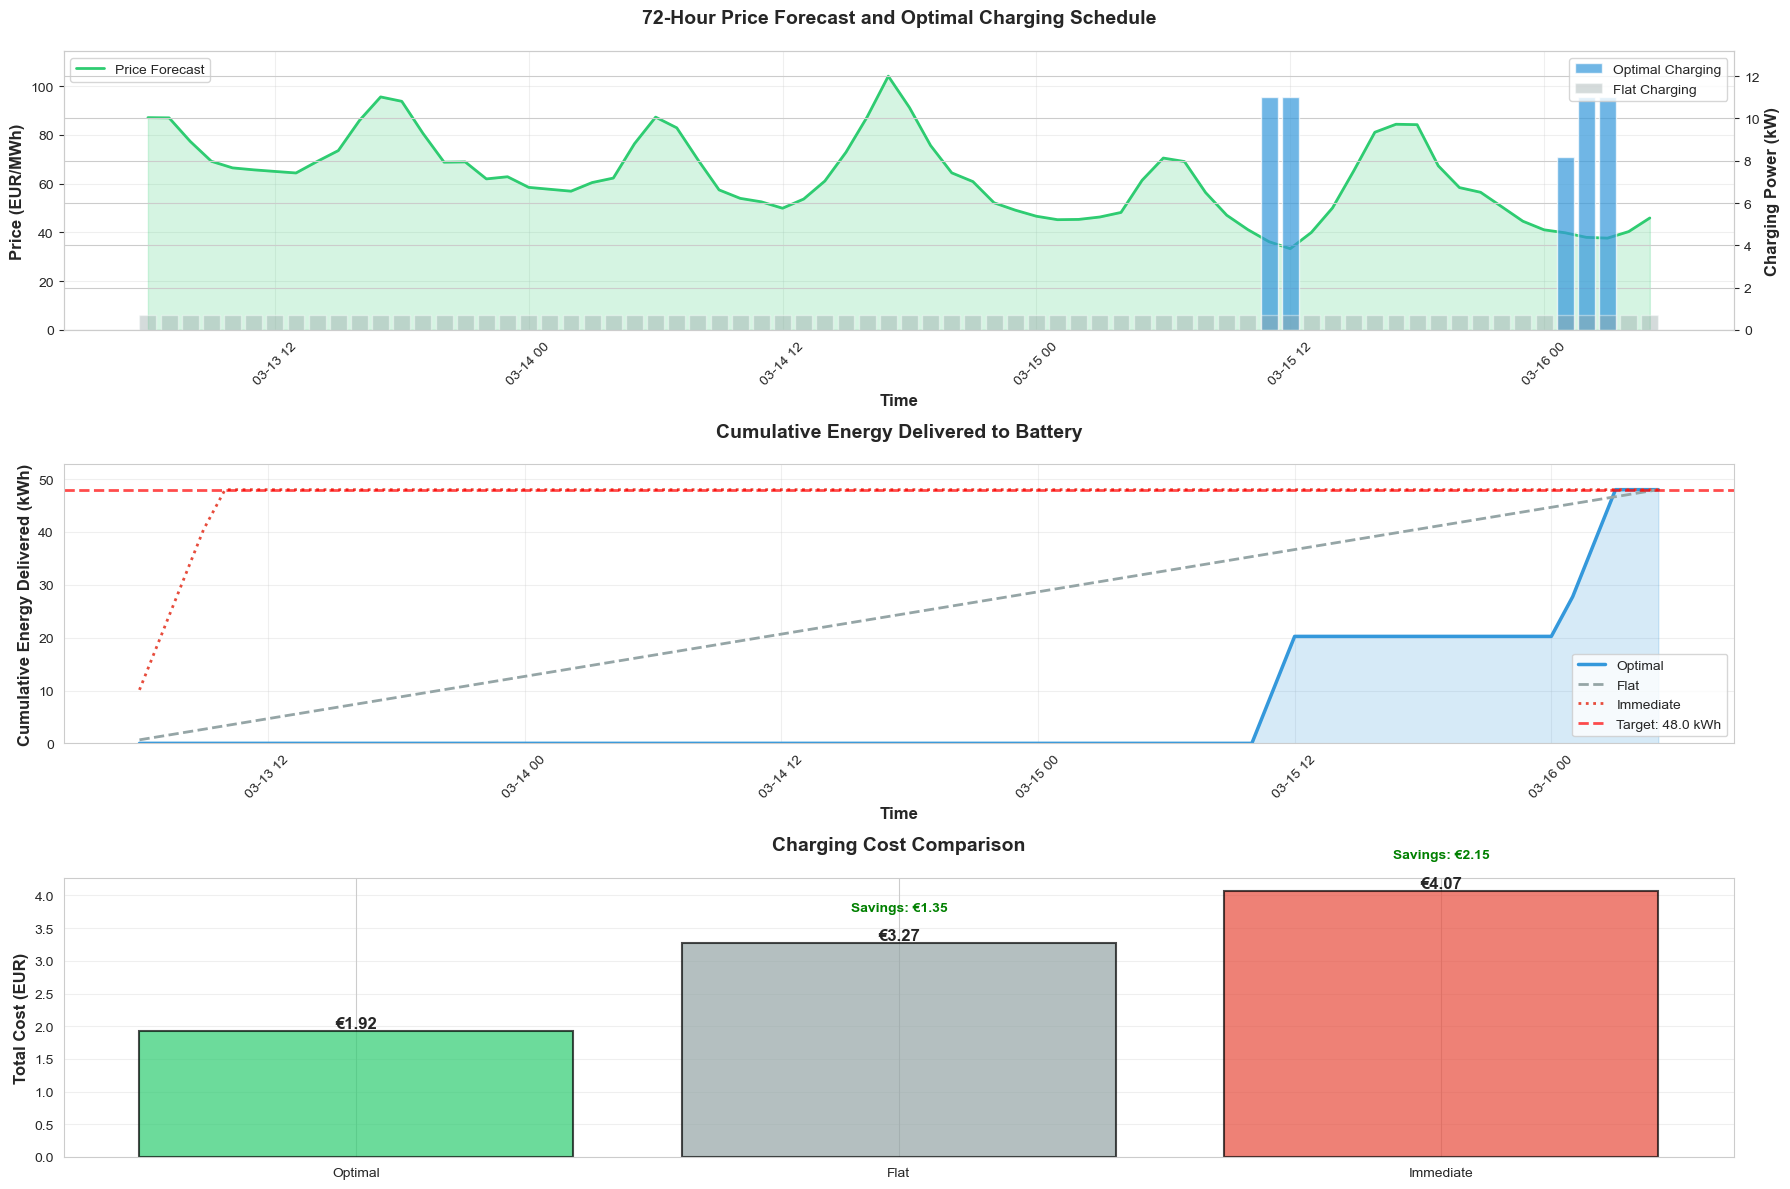

✓ Detailed schedule exported to data/processed/ev_charging_schedule_72h.csv

OPTIMIZATION SUMMARY - READY FOR PRESENTATION
Forecast Period................................... 2024-03-13 06:00:00 to 2024-03-16 05:00:00
Forecast Horizon.................................. 72 hours
Battery Capacity.................................. 60.0 kWh
Initial SOC....................................... 20%
Target SOC........................................ 100%
Energy Required................................... 48.00 kWh
Charging Efficiency............................... 92%
Max Charge Rate................................... 11.0 kW
Forecast MAE (Ensemble)........................... €0.42/MWh
Optimal Cost...................................... €1.92
Flat Cost......................................... €3.27
Immediate Cost.................................... €4.07
Savings vs Flat................................... €1.35 (41.2%)
Savings vs Immediate.............................. €2.15 (52.8%)
Optimal Hours U

In [1]:
"""
05_optimization_single_charge.ipynb

EV Charging Cost Optimization using 72-hour electricity price forecasts.

Problem: Minimize total charging cost over 72 hours given:
- Hourly price forecasts from trained models (LightGBM, XGBoost, CNN-LSTM)
- Battery capacity and charging constraints
- Initial and target state of charge

Business goal: Find optimal charging schedule to reach target SOC at lowest cost.

"""

# %% Setup and Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from datetime import datetime, timedelta
import joblib
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

# %% Load Data and Models

# Load processed data
df = pd.read_csv('data/processed/electricity_prices_features.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

target_col = 'price_eur_mwh'
timestamp_col = 'timestamp'
feature_cols = [c for c in df.columns if c not in [target_col, timestamp_col]]

# Train/validation/test split (same as training)
split1 = int(len(df) * 0.7)
split2 = int(len(df) * 0.85)
train = df.iloc[:split1]
val = df.iloc[split1:split2]
test = df.iloc[split2:]

# Load trained models
lgb_model = joblib.load('models/lightgbm_model.pkl')
xgb_model = joblib.load('models/xgboost_model.pkl')

print("Models loaded successfully!")
print(f"Test set: {len(test)} hours ({test['timestamp'].min()} to {test['timestamp'].max()})")

# %% Generate 72-Hour Price Forecasts from Multiple Models

FORECAST_HORIZON = 72

# Ensure we have enough test data
if len(test) < FORECAST_HORIZON:
    print(f"Warning: Test set only has {len(test)} hours, using all available data")
    FORECAST_HORIZON = len(test)

# Extract features and timestamps for forecast period
X_forecast = test[feature_cols].iloc[:FORECAST_HORIZON]
y_actual = test[target_col].iloc[:FORECAST_HORIZON].values
time_index = test[timestamp_col].iloc[:FORECAST_HORIZON].reset_index(drop=True)

# Generate forecasts from both models
price_forecast_lgb = lgb_model.predict(X_forecast)
price_forecast_xgb = xgb_model.predict(X_forecast)

# Ensemble: average of both models for robustness
price_forecast = (price_forecast_lgb + price_forecast_xgb) / 2

print(f"\n72-Hour Price Forecast Statistics:")
print(f"  Mean price: €{price_forecast.mean():.2f}/MWh")
print(f"  Min price:  €{price_forecast.min():.2f}/MWh at {time_index[price_forecast.argmin()]}")
print(f"  Max price:  €{price_forecast.max():.2f}/MWh at {time_index[price_forecast.argmax()]}")
print(f"  LightGBM MAE: €{mean_absolute_error(y_actual, price_forecast_lgb):.2f}/MWh")
print(f"  XGBoost MAE:  €{mean_absolute_error(y_actual, price_forecast_xgb):.2f}/MWh")
print(f"  Ensemble MAE: €{mean_absolute_error(y_actual, price_forecast):.2f}/MWh")

# %% EV Battery and Charging Parameters

# Typical EV specifications (e.g., Tesla Model 3, Nissan Leaf)
EV_BATTERY_KWH = 60.0        # Total battery capacity (kWh)
EV_INITIAL_SOC = 0.20        # Initial state of charge (20%)
EV_TARGET_SOC = 1.00         # Target SOC (100% - fully charged)
EV_CHARGE_POWER_KW = 11.0    # Max charge rate (kW) - Level 2 charger
CHARGING_EFFICIENCY = 0.92   # Realistic charging efficiency (8% loss)

# Calculate energy requirement
kWh_needed = EV_BATTERY_KWH * (EV_TARGET_SOC - EV_INITIAL_SOC)
kWh_to_charge = kWh_needed / CHARGING_EFFICIENCY  # Account for losses

print(f"\nEV Charging Requirements:")
print(f"  Battery capacity: {EV_BATTERY_KWH} kWh")
print(f"  Initial SOC: {EV_INITIAL_SOC:.0%} ({EV_INITIAL_SOC * EV_BATTERY_KWH:.1f} kWh)")
print(f"  Target SOC: {EV_TARGET_SOC:.0%} ({EV_TARGET_SOC * EV_BATTERY_KWH:.1f} kWh)")
print(f"  Energy needed: {kWh_needed:.2f} kWh")
print(f"  Energy to charge (with {(1-CHARGING_EFFICIENCY)*100:.0f}% loss): {kWh_to_charge:.2f} kWh")
print(f"  Max charge rate: {EV_CHARGE_POWER_KW} kW")
print(f"  Min hours needed: {kWh_to_charge / EV_CHARGE_POWER_KW:.1f} hours")

# %% Optimization Model: Minimize Charging Cost

# Create optimization problem
problem = pulp.LpProblem('EV_Charging_Cost_Minimization', pulp.LpMinimize)

# Decision variables: charging power per hour (kW)
charge_kw = pulp.LpVariable.dicts(
    'charge_kw', 
    range(FORECAST_HORIZON), 
    lowBound=0, 
    upBound=EV_CHARGE_POWER_KW, 
    cat='Continuous'
)

# Objective function: minimize total cost
# Cost = sum of (hourly_charge_kW * price_EUR_per_MWh / 1000)
total_cost = pulp.lpSum([
    charge_kw[i] * (price_forecast[i] / 1000.0)  # Convert EUR/MWh to EUR/kWh
    for i in range(FORECAST_HORIZON)
])
problem += total_cost, "Total_Charging_Cost"

# Constraint 1: Meet energy requirement
problem += (
    pulp.lpSum([charge_kw[i] for i in range(FORECAST_HORIZON)]) >= kWh_to_charge,
    "Energy_Requirement"
)

# Constraint 2: Charge rate limits (already handled by variable bounds, but explicit for clarity)
for i in range(FORECAST_HORIZON):
    problem += charge_kw[i] <= EV_CHARGE_POWER_KW, f"Max_Charge_Hour_{i}"
    problem += charge_kw[i] >= 0, f"Min_Charge_Hour_{i}"

# Solve optimization
print("\nSolving optimization problem...")
solver_status = problem.solve(pulp.PULP_CBC_CMD(msg=0))

# Check solution status
if pulp.LpStatus[solver_status] != 'Optimal':
    print(f"Warning: Optimization status: {pulp.LpStatus[solver_status]}")
else:
    print("✓ Optimal solution found!")

# %% Extract Optimal Charging Schedule

# Extract decision variable values
optimal_schedule = np.array([charge_kw[i].varValue for i in range(FORECAST_HORIZON)])
optimal_energy_charged = optimal_schedule.sum()
optimal_energy_delivered = optimal_energy_charged * CHARGING_EFFICIENCY
optimal_total_cost = np.sum(optimal_schedule * price_forecast / 1000.0)

print(f"\nOptimal Charging Schedule:")
print(f"  Total energy charged: {optimal_energy_charged:.2f} kWh")
print(f"  Energy delivered to battery: {optimal_energy_delivered:.2f} kWh")
print(f"  Total cost: €{optimal_total_cost:.2f}")
print(f"  Average cost: €{(optimal_total_cost / optimal_energy_charged):.4f}/kWh")
print(f"  Charging hours used: {np.sum(optimal_schedule > 0.01)}")

# Identify optimal charging windows
charging_hours = np.where(optimal_schedule > 0.01)[0]
if len(charging_hours) > 0:
    print(f"\nCharging windows (hours with >0.01 kW):")
    for h in charging_hours[:10]:  # Show first 10
        print(f"  Hour {h}: {time_index[h]} - {optimal_schedule[h]:.2f} kW at €{price_forecast[h]:.2f}/MWh")
    if len(charging_hours) > 10:
        print(f"  ... and {len(charging_hours)-10} more hours")

# %% Baseline Comparison: Flat (Uniform) Charging

# Flat charging: spread energy evenly across all 72 hours
flat_charge_per_hour = kWh_to_charge / FORECAST_HORIZON
flat_schedule = np.ones(FORECAST_HORIZON) * flat_charge_per_hour
flat_total_cost = np.sum(flat_schedule * price_forecast / 1000.0)
flat_energy_delivered = flat_schedule.sum() * CHARGING_EFFICIENCY

print(f"\nFlat Charging Baseline:")
print(f"  Total energy charged: {flat_schedule.sum():.2f} kWh")
print(f"  Energy delivered to battery: {flat_energy_delivered:.2f} kWh")
print(f"  Total cost: €{flat_total_cost:.2f}")
print(f"  Average cost: €{(flat_total_cost / flat_schedule.sum()):.4f}/kWh")

# %% Baseline Comparison: Immediate Charging (ASAP)

# Immediate charging: charge at max rate until full
immediate_schedule = np.zeros(FORECAST_HORIZON)
hours_needed = int(np.ceil(kWh_to_charge / EV_CHARGE_POWER_KW))
immediate_schedule[:hours_needed-1] = EV_CHARGE_POWER_KW
remaining = kWh_to_charge - (hours_needed-1) * EV_CHARGE_POWER_KW
immediate_schedule[hours_needed-1] = remaining
immediate_total_cost = np.sum(immediate_schedule * price_forecast / 1000.0)
immediate_energy_delivered = immediate_schedule.sum() * CHARGING_EFFICIENCY

print(f"\nImmediate (ASAP) Charging Baseline:")
print(f"  Total energy charged: {immediate_schedule.sum():.2f} kWh")
print(f"  Energy delivered to battery: {immediate_energy_delivered:.2f} kWh")
print(f"  Total cost: €{immediate_total_cost:.2f}")
print(f"  Average cost: €{(immediate_total_cost / immediate_schedule.sum()):.4f}/kWh")
print(f"  Charging duration: {hours_needed} hours")

# %% Cost Savings Summary

print(f"\n{'='*60}")
print(f"COST SAVINGS ANALYSIS")
print(f"{'='*60}")
print(f"Optimal cost:    €{optimal_total_cost:.2f}")
print(f"Flat cost:       €{flat_total_cost:.2f} → Savings: €{flat_total_cost - optimal_total_cost:.2f} ({(flat_total_cost - optimal_total_cost)/flat_total_cost*100:.1f}%)")
print(f"Immediate cost:  €{immediate_total_cost:.2f} → Savings: €{immediate_total_cost - optimal_total_cost:.2f} ({(immediate_total_cost - optimal_total_cost)/immediate_total_cost*100:.1f}%)")
print(f"{'='*60}\n")

# %% Visualization: Charging Schedule and Prices

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Plot 1: Price forecast and charging schedules
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Price line
ax1.plot(time_index, price_forecast, color='#2ecc71', linewidth=2, label='Price Forecast', zorder=1)
ax1.fill_between(time_index, price_forecast, alpha=0.2, color='#2ecc71')
ax1.set_ylabel('Price (EUR/MWh)', fontsize=12, fontweight='bold')
ax1.set_ylim([0, max(price_forecast) * 1.1])
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Charging schedules as bars
width = 0.8 / 24  # Convert to fractional days for better visibility
ax1_twin.bar(time_index, optimal_schedule, width=width, alpha=0.7, color='#3498db', label='Optimal Charging')
ax1_twin.bar(time_index, flat_schedule, width=width, alpha=0.4, color='#95a5a6', label='Flat Charging')
ax1_twin.set_ylabel('Charging Power (kW)', fontsize=12, fontweight='bold')
ax1_twin.set_ylim([0, EV_CHARGE_POWER_KW * 1.2])
ax1_twin.legend(loc='upper right', fontsize=10)

ax1.set_title('72-Hour Price Forecast and Optimal Charging Schedule', fontsize=14, fontweight='bold', pad=20)

# Plot 2: Cumulative energy charged
ax2 = axes[1]
optimal_cumulative = np.cumsum(optimal_schedule) * CHARGING_EFFICIENCY
flat_cumulative = np.cumsum(flat_schedule) * CHARGING_EFFICIENCY
immediate_cumulative = np.cumsum(immediate_schedule) * CHARGING_EFFICIENCY

ax2.plot(time_index, optimal_cumulative, linewidth=2.5, label='Optimal', color='#3498db')
ax2.plot(time_index, flat_cumulative, linewidth=2, linestyle='--', label='Flat', color='#95a5a6')
ax2.plot(time_index, immediate_cumulative, linewidth=2, linestyle=':', label='Immediate', color='#e74c3c')
ax2.axhline(kWh_needed, color='red', linestyle='--', linewidth=2, label=f'Target: {kWh_needed:.1f} kWh', alpha=0.7)
ax2.fill_between(time_index, 0, optimal_cumulative, alpha=0.2, color='#3498db')
ax2.set_ylabel('Cumulative Energy Delivered (kWh)', fontsize=12, fontweight='bold')
ax2.set_ylim([0, kWh_needed * 1.1])
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_title('Cumulative Energy Delivered to Battery', fontsize=14, fontweight='bold', pad=20)

# Plot 3: Cost comparison bars
ax3 = axes[2]
strategies = ['Optimal', 'Flat', 'Immediate']
costs = [optimal_total_cost, flat_total_cost, immediate_total_cost]
colors = ['#2ecc71', '#95a5a6', '#e74c3c']
bars = ax3.bar(strategies, costs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'€{cost:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add savings annotations
ax3.text(1, flat_total_cost + 0.5, f'Savings: €{flat_total_cost - optimal_total_cost:.2f}', 
         ha='center', fontsize=10, color='green', fontweight='bold')
ax3.text(2, immediate_total_cost + 0.5, f'Savings: €{immediate_total_cost - optimal_total_cost:.2f}', 
         ha='center', fontsize=10, color='green', fontweight='bold')

ax3.set_ylabel('Total Cost (EUR)', fontsize=12, fontweight='bold')
ax3.set_title('Charging Cost Comparison', fontsize=14, fontweight='bold', pad=20)
ax3.grid(True, alpha=0.3, axis='y')

# Format x-axis for all subplots
for ax in [axes[0], axes[1]]:
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('data/processed/05_ev_charging_optimization.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to data/processed/05_ev_charging_optimization.png")
plt.show()

# %% Export Detailed Schedule

schedule_df = pd.DataFrame({
    'timestamp': time_index,
    'hour': range(FORECAST_HORIZON),
    'price_eur_mwh': price_forecast,
    'price_eur_kwh': price_forecast / 1000,
    'charge_kw_optimal': optimal_schedule,
    'charge_kw_flat': flat_schedule,
    'charge_kw_immediate': immediate_schedule,
    'cost_eur_optimal': optimal_schedule * price_forecast / 1000,
    'cost_eur_flat': flat_schedule * price_forecast / 1000,
    'cost_eur_immediate': immediate_schedule * price_forecast / 1000,
    'cumulative_kwh_optimal': np.cumsum(optimal_schedule) * CHARGING_EFFICIENCY,
    'cumulative_kwh_flat': np.cumsum(flat_schedule) * CHARGING_EFFICIENCY,
})

schedule_df.to_csv('data/processed/ev_charging_schedule_72h.csv', index=False)
print("✓ Detailed schedule exported to data/processed/ev_charging_schedule_72h.csv")

# %% Summary Report for Presentation

summary = {
    'Forecast Period': f"{time_index.iloc[0]} to {time_index.iloc[-1]}",
    'Forecast Horizon': f"{FORECAST_HORIZON} hours",
    'Battery Capacity': f"{EV_BATTERY_KWH} kWh",
    'Initial SOC': f"{EV_INITIAL_SOC:.0%}",
    'Target SOC': f"{EV_TARGET_SOC:.0%}",
    'Energy Required': f"{kWh_needed:.2f} kWh",
    'Charging Efficiency': f"{CHARGING_EFFICIENCY:.0%}",
    'Max Charge Rate': f"{EV_CHARGE_POWER_KW} kW",
    'Forecast MAE (Ensemble)': f"€{mean_absolute_error(y_actual, price_forecast):.2f}/MWh",
    'Optimal Cost': f"€{optimal_total_cost:.2f}",
    'Flat Cost': f"€{flat_total_cost:.2f}",
    'Immediate Cost': f"€{immediate_total_cost:.2f}",
    'Savings vs Flat': f"€{flat_total_cost - optimal_total_cost:.2f} ({(flat_total_cost - optimal_total_cost)/flat_total_cost*100:.1f}%)",
    'Savings vs Immediate': f"€{immediate_total_cost - optimal_total_cost:.2f} ({(immediate_total_cost - optimal_total_cost)/immediate_total_cost*100:.1f}%)",
    'Optimal Hours Used': f"{np.sum(optimal_schedule > 0.01)} hours",
}

summary_df = pd.DataFrame(summary.items(), columns=['Metric', 'Value'])
summary_df.to_csv('data/processed/optimization_summary.csv', index=False)

print("\n" + "="*70)
print("OPTIMIZATION SUMMARY - READY FOR PRESENTATION")
print("="*70)
for metric, value in summary.items():
    print(f"{metric:.<50} {value}")
print("="*70)

print("\n✓ Optimization complete!")
print("✓ All results saved to data/processed/")
print("✓ Ready to present to senior data scientist / recruiter")
